<h1><center> REINFORCEMENT LEARNING </center></h1>
<h2><center> THE FROZEN LAKE EXAMPLE </center></h2>

The material from this section comes from: **Juliany, A (2016) `Simple Reinforcement Learning with Tensorflow`**

https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0

## 1. MOTIVATION

Instead of starting with a complex and unwieldy deep neural network, we will begin by implementing a simple **lookup-table version of the algorithm**, and then show how to implement a neural-network equivalent using Tensorflow. Given that we are going back to basics, it may be best to think of this as Part-0 of the series. It will hopefully give an intuition into what is really happening in Q-Learning that we can then build on going forward when we eventually combine the policy gradient and Q-learning approaches to build state-of-the-art RL agents 

### 1.1. THE END GAME OF THE Q-LEARNING ALGORITHM

**`Q-Learning attempts to learn the value of being in a given state, and taking a specific action there.`**

### 1.2. USING VIDEOGAMES AT THE OPEN AI GYM: THE FROZEN LAKE

For those unfamiliar, the OpenAI gym provides an easy way for people to experiment with their learning agents in an array of provided toy games. The FrozenLake environment consists of a 4x4 grid of blocks, each one either being the start block, the goal block, a safe frozen block, or a dangerous hole. The objective is to have an agent learn to navigate from the start to the goal without moving onto a hole. At any given time the agent can choose to move either up, down, left, or right. The catch is that there is a wind which occasionally blows the agent onto a space they didn’t choose. As such, perfect performance every time is impossible, but learning to avoid the holes and reach the goal are certainly still doable. The reward at every step is 0, except for entering the goal, which provides a reward of 1. Thus, we will need an algorithm that learns long-term expected rewards. This is exactly what Q-Learning is designed to provide.

## 2. FINDING THE Q-LEARNING TABLE

In the case of the FrozenLake environment, we have 16 possible states (one for each block), and 4 possible actions (the four directions of movement), giving us a 16x4 table of Q-values. We start by initializing the table to be uniform (all zeros), and then as we observe the rewards we obtain for various actions, we update the table accordingly.

We make updates to our Q-table using something called the Bellman equation, which states that the expected long-term reward for a given action is equal to the immediate reward from the current action combined with the expected reward from the best future action taken at the following state. In this way, we reuse our own Q-table when estimating how to update our table for future actions! In equation form, the rule looks like this: $Q(s,a) = r+\gamma(max(Q(s',a'a))$

This says that the Q-value for a given state (s) and action (a) should represent the current reward (r) plus the maximum discounted (γ) future reward expected according to our own table for the next state (s’) we would end up in. The discount variable allows us to decide how important the possible future rewards are compared to the present reward. By updating in this way, the table slowly begins to obtain accurate measures of the expected future reward for a given action in a given state. Below is a Python walkthrough of the Q-Table algorithm implemented in the FrozenLake environment:

https://www.youtube.com/watch?v=QK_PP_2KgGE

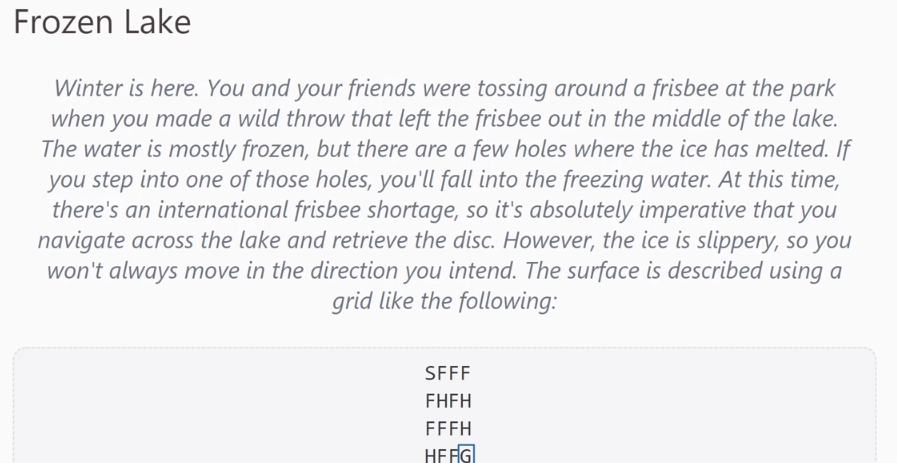

In [1]:
import gym
import numpy as np
import random
import time
from IPython.display import clear_output

In [2]:
env = gym.make('FrozenLake-v0')

In [3]:
dir(env)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_elapsed_steps',
 '_max_episode_steps',
 'action_space',
 'class_name',
 'close',
 'compute_reward',
 'env',
 'metadata',
 'observation_space',
 'render',
 'reset',
 'reward_range',
 'seed',
 'spec',
 'step',
 'unwrapped']

Here we will construt the $Q(s,a)$ before we start making any computation.

In [5]:
action_space_size=env.action_space.n
state_space_size=env.observation_space.n
q_table=np.zeros((state_space_size, action_space_size))

In [6]:
print(q_table)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


### PARAMETERS

In [60]:
# Number of times the agent will play the game
num_episodes=10000
max_steps_per_episode=100


learning_rate=0.1
discount_rate=0.99

# Exploration explotation trade-off (greedyness)
exploration_rate=1
max_exploration_rate=1
min_exploration_rate=0.01
exploration_decay_rate=0.001

https://www.youtube.com/watch?v=HGeI30uATws&list=PLZbbT5o_s2xoWNVdDudn51XM8lOuZ_Njv&index=9

https://www.youtube.com/watch?v=ZaILVnqZFCg

https://deeplizard.com/learn/video/HGeI30uATws

### RUNNING THE CODE

In [61]:
rewards_all_episodes=[]

#Q-Learning Algorithm
# Each Episode
for episode in range(num_episodes):
    state=env.reset()
    done=False
    rewards_current_episode =0
    
    #Each step
    for step in range(max_steps_per_episode):
        #Exploration-exploitation trade off is randomized
        exploration_rate_threshold=random.uniform(0,1)
        if exploration_rate_threshold>exploration_rate:
            action=np.argmax(q_table[state,:])
        else:
            action=env.action_space.sample()
        
        new_state, reward, done, info = env.step(action)
        
        #Update Q-table for Q(s,a)
        q_table[state, action] = q_table[state, action] * (1 - learning_rate) + \
            learning_rate * (reward + discount_rate * np.max(q_table[new_state, :]))
        state = new_state
        rewards_current_episode += reward
        
        if done==True:
            break
   
    # Exploration rate decay
    exploration_rate = min_exploration_rate + \
    (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate*episode) 
    
    rewards_all_episodes.append(rewards_current_episode)
                          
# Calculate and print the average reward per thousand episodes
rewards_per_thousand_episodes = np.split(np.array(rewards_all_episodes),num_episodes/1000)
count = 1000

print("********Average reward per thousand episodes********\n")
for r in rewards_per_thousand_episodes:
    print(count, ": ", str(sum(r/1000)))
    count += 1000   
        

********Average reward per thousand episodes********

1000 :  0.04000000000000003
2000 :  0.21800000000000017
3000 :  0.3790000000000003
4000 :  0.5790000000000004
5000 :  0.6420000000000005
6000 :  0.6650000000000005
7000 :  0.6740000000000005
8000 :  0.6640000000000005
9000 :  0.6820000000000005
10000 :  0.6920000000000005


What the model shows is that the Q table is updated in each one of the episodes in a way that the user becomes more informed and therefore more effective in discovering the path. The agent is capable of getting to the goal 70% of the time after 10,000 episodes and  72% after 50,000 episodes.

### OBTAINING THE Q TABLE

In [62]:
final_q=q_table
print(final_q)

[[0.53992229 0.52406567 0.52162678 0.52147711]
 [0.2981899  0.19496984 0.42393162 0.50202267]
 [0.41585397 0.41102744 0.40559887 0.47029422]
 [0.22879239 0.2766237  0.27280647 0.4591966 ]
 [0.55507759 0.42752143 0.30440959 0.31315335]
 [0.         0.         0.         0.        ]
 [0.40093785 0.15967809 0.20833794 0.11831086]
 [0.         0.         0.         0.        ]
 [0.43193838 0.35013299 0.36695611 0.59772575]
 [0.3638107  0.62145876 0.50403321 0.37736467]
 [0.57181653 0.47566624 0.44712248 0.28963763]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.44608591 0.63572736 0.73816818 0.52889669]
 [0.72821906 0.84533566 0.72223271 0.71440404]
 [0.         0.         0.         0.        ]]


### DISPLAY THE Q TABLE

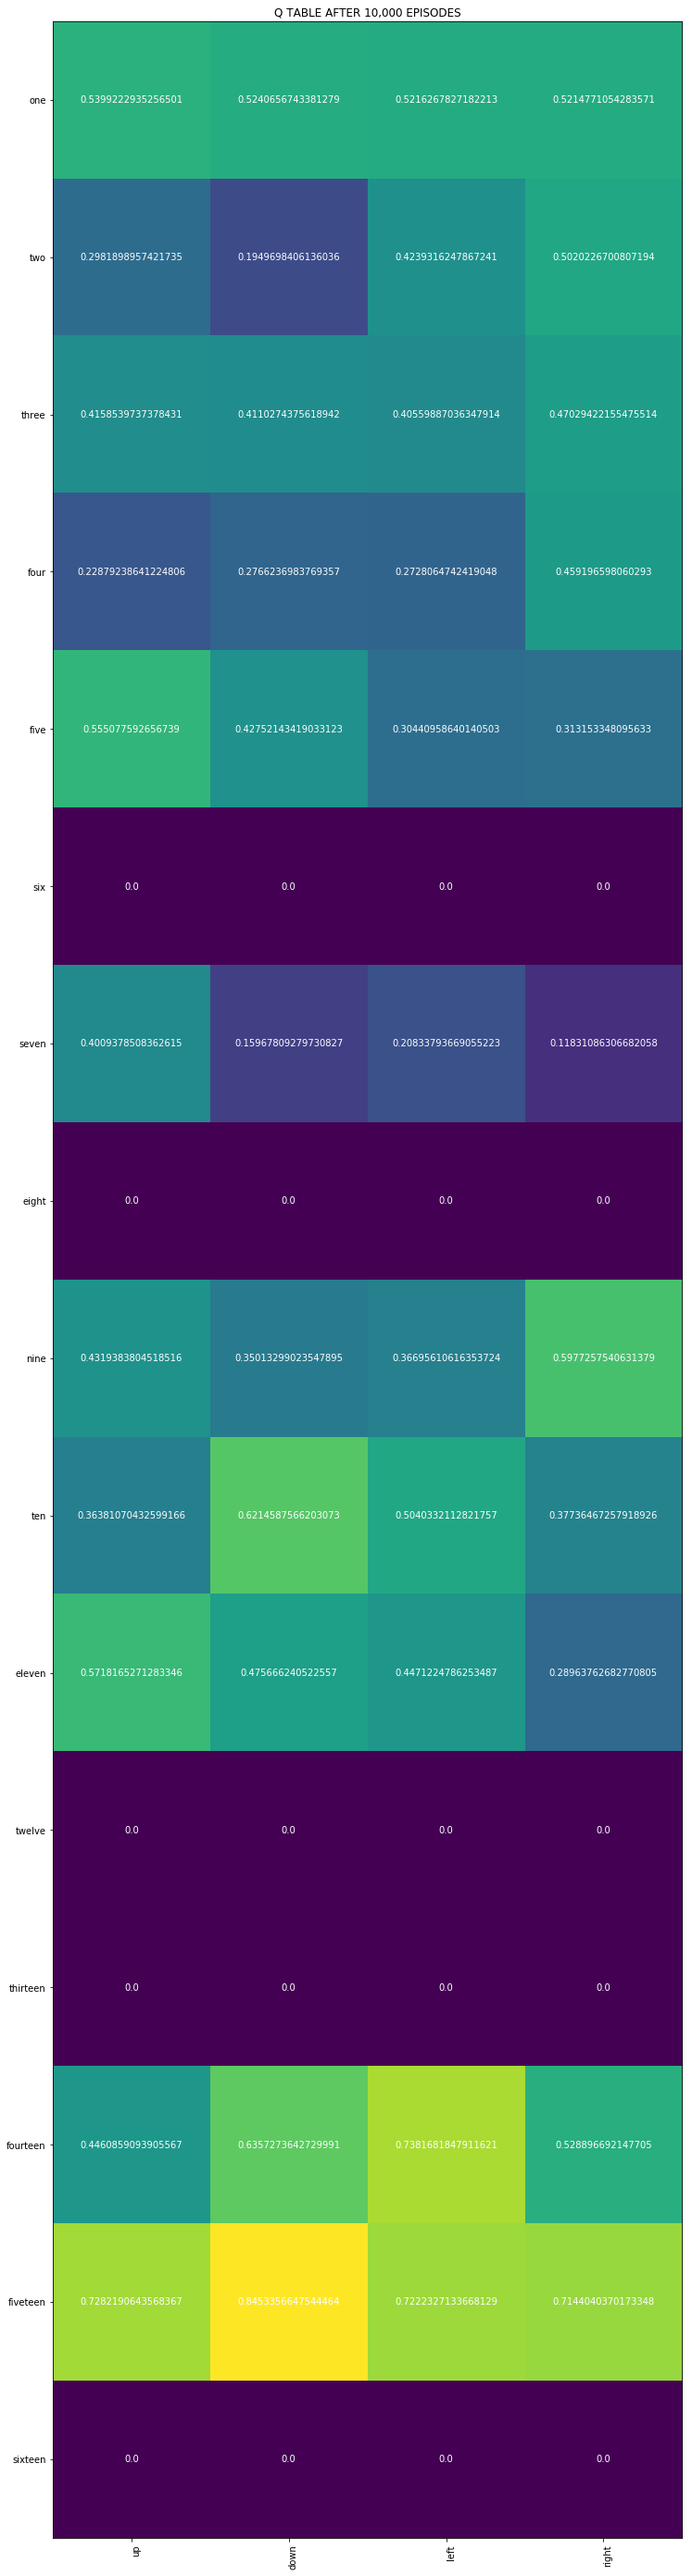

In [63]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#sphinx_gallery_thumbnail_number = 10

actions = ["up", "down", "left", "right"]
positions = ['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'eleven', 
             'twelve', 'thirteen', 'fourteen', 'fiveteen', 'sixteen']

fig, ax = plt.subplots(figsize=(50,50))
im = ax.imshow(final_q)

# We want to show all ticks...
ax.set_xticks(np.arange(len(actions)))
ax.set_yticks(np.arange(len(positions)))
# ... and label them with the respective list entries
ax.set_xticklabels(actions)
ax.set_yticklabels(positions)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(positions)):
    for j in range(len(actions)):
        text = ax.text(j, i, final_q[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Q TABLE AFTER 10,000 EPISODES")
#fig.tight_layout()
plt.show()